In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import json
import os
import importlib
import pprint as pp

from tqdm import tqdm

import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sc
import nltk

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import gensim
import spacy
import string

# Load all JSON files from the final dataset summary_json_final

In [10]:
source_summary_analysis = r"C:\Users\jonas\GDPR_project\summary_json_final"

country_list = ["austria", "italy", "poland", "spain", "ireland","portugal","france","netherlands","belgium"]


path_country_list = [os.path.join(source_summary_analysis, country + "_qr_results") for country in country_list]

results = {}


for country, path in zip(country_list, path_country_list):
        
        results[country] = []

        for root, dirs, files in os.walk(path):
            found = 0
            for file in files:
                if file == "tj1.0.json":
                    with open(os.path.join(root, file), "r") as f:
                        j = json.load(f)
                        results[country].append(j)
                    found = 1
            if found == 0:
                print(f"No file found in {root}")







No file found in C:\Users\jonas\GDPR_project\summary_json_final\austria_qr_results
No file found in C:\Users\jonas\GDPR_project\summary_json_final\austria_qr_results\Datenschutzbehorde
No file found in C:\Users\jonas\GDPR_project\summary_json_final\austria_qr_results\Datenschutzbehorde\Bescheid_amtswegiges_Prufverfahren
No file found in C:\Users\jonas\GDPR_project\summary_json_final\austria_qr_results\Datenschutzbehorde\Bescheid_Beschwerde
No file found in C:\Users\jonas\GDPR_project\summary_json_final\austria_qr_results\Datenschutzbehorde\Bescheid_sonstiger
No file found in C:\Users\jonas\GDPR_project\summary_json_final\austria_qr_results\Datenschutzbehorde\Bescheid_Warnung
No file found in C:\Users\jonas\GDPR_project\summary_json_final\italy_qr_results
No file found in C:\Users\jonas\GDPR_project\summary_json_final\italy_qr_results\GPDP
No file found in C:\Users\jonas\GDPR_project\summary_json_final\italy_qr_results\GPDP\Divieto_del_trattamento
No file found in C:\Users\jonas\GDPR_pr

Length of datasets

In [11]:
for key in results.keys():
    print('Number of files in results dataset for country : ', key)
    print(len(results[key]))
    

Number of files in results dataset for country :  austria
65
Number of files in results dataset for country :  italy
320
Number of files in results dataset for country :  poland
316
Number of files in results dataset for country :  spain
1224
Number of files in results dataset for country :  ireland
23
Number of files in results dataset for country :  portugal
21
Number of files in results dataset for country :  france
34
Number of files in results dataset for country :  netherlands
18
Number of files in results dataset for country :  belgium
189


In [ ]:
""""
Size of possible dataset for each country:

Austria: 80
Italy: 346
Poland: 320
Spain: 1253
Ireland: 23
Belgium: 203
Netherlands: 18
Portugal: 21
France: 34
""""

[65, 320, 316, 1224, 23, 21, 34, 18, 189]


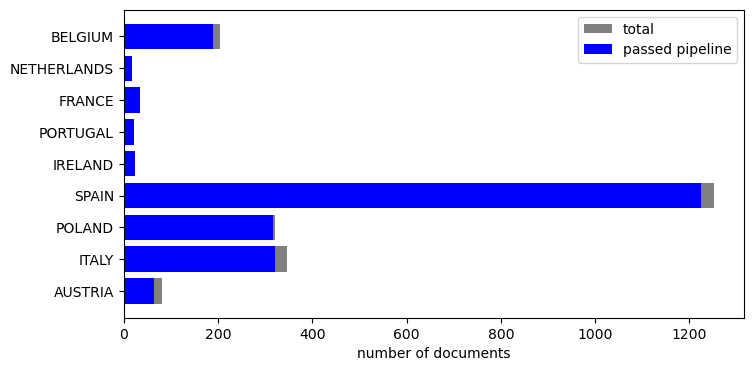

In [18]:
total_docs = [80,346,320,1253,23,21,34,18,203]
upper_country_list = [country.upper() for country in country_list]
passed_docs = [len(results[country.lower()]) for country in country_list]
print(passed_docs)



plt.figure(figsize=(8,4))
plt.barh(upper_country_list, total_docs, color='grey', label = "total")
plt.barh(upper_country_list, passed_docs, color = 'blue', label = "passed pipeline")
plt.xlabel("number of documents")
plt.legend()
plt.savefig(r"Figures/number_of_documents.png")
plt.show()



Complainant analysis

In [29]:
complainant_yn_sum = {}

for country in results.keys():

    complainant_yn_sum[country] = {}
    complainant_yn_sum[country]['not_DPA'] = 0
    complainant_yn_sum[country]['DPA'] = 0
    complainant_yn_sum[country]['no'] = 0
    complainant_yn_sum[country]['other'] = 0
    complainant_yn_sum[country]['n/a'] = 0

    for i in range(len(results[country])):

        complainant = results[country][i].get('complainant', None)

        if complainant:
            
            complainant_yn = complainant.get('complainant_yn', None)

            if complainant_yn:
                if complainant_yn == 'yes':

                    compl_name = str(complainant.get('complainant_name', None)).strip('').strip('[]').lower()


                    if compl_name:
                        parts = compl_name.split(' ')
                        if (compl_name in ["data protection agency", "data protection authority","dpa","garante per la protezione dei dati personali"]
                            or 
                            np.any([part.strip('(').strip(')') in ["dpa","aepd","dsb","apd","gba","apd-gba","cnil","gpdp","giodo","cnpd"] for part in parts])):
                            complainant_yn_sum[country]['DPA'] += 1
                            #print(compl_name, country, i, complainant_yn)
                        else:
                            complainant_yn_sum[country]['not_DPA'] += 1
                            #print(compl_name, country, i, complainant_yn)

                           

                elif complainant_yn == 'no':

                    initiator_is_DPA_yn = complainant.get('initiator_is_DPA_yn', None)

                    if initiator_is_DPA_yn:

                        if initiator_is_DPA_yn == 'yes':
                            complainant_yn_sum[country]['DPA'] += 1
                            #print(compl_name, country, i, complainant_yn, initiator_is_DPA_yn)
                            

                    else: 
                        complainant_yn_sum[country]['no'] += 1        
                            

                else:
                    complainant_yn_sum[country]['other'] += 1
            else:
                complainant_yn_sum[country]['n/a'] += 1
        else:
            complainant_yn_sum[country]['n/a'] += 1


pp.pprint(complainant_yn_sum)
        

{'austria': {'DPA': 0, 'n/a': 1, 'no': 0, 'not_DPA': 63, 'other': 0},
 'belgium': {'DPA': 1, 'n/a': 0, 'no': 1, 'not_DPA': 179, 'other': 1},
 'france': {'DPA': 6, 'n/a': 0, 'no': 1, 'not_DPA': 16, 'other': 1},
 'ireland': {'DPA': 12, 'n/a': 1, 'no': 4, 'not_DPA': 6, 'other': 0},
 'italy': {'DPA': 52, 'n/a': 1, 'no': 2, 'not_DPA': 190, 'other': 3},
 'netherlands': {'DPA': 2, 'n/a': 0, 'no': 0, 'not_DPA': 9, 'other': 0},
 'poland': {'DPA': 2, 'n/a': 0, 'no': 0, 'not_DPA': 298, 'other': 0},
 'portugal': {'DPA': 3, 'n/a': 0, 'no': 1, 'not_DPA': 6, 'other': 0},
 'spain': {'DPA': 9, 'n/a': 4, 'no': 1, 'not_DPA': 1206, 'other': 0}}


In [31]:
def get_complainant_yn(json_object):

    complainant = json_object.get('complainant', None)

    if complainant:
        
        complainant_yn = complainant.get('complainant_yn', None)

        if complainant_yn:
            if complainant_yn == 'yes':

                compl_name = str(complainant.get('complainant_name', None)).strip('').strip('[]').lower()


                if compl_name:
                    parts = compl_name.split(' ')
                    if (compl_name in ["data protection agency", "data protection authority","dpa","garante per la protezione dei dati personali"]
                        or 
                        np.any([part.strip('()') in ["dpa","aepd","dsb","apd","gba","apd-gba","cnil","gpdp","giodo","cnpd"] for part in parts])):
                        return 'DPA'
                    else:
                        return 'not_DPA'

            elif complainant_yn == 'no':

                initiator_is_DPA_yn = complainant.get('initiator_is_DPA_yn', None)

                if initiator_is_DPA_yn:

                    if initiator_is_DPA_yn == 'yes':
                        return 'DPA'

                else: 
                    return 'no'      
                        

            else:
                return 'other'
        else:
            return 'n/a'
    else:
        return 'n/a'

Complainant category analysis

In [36]:
complainant_category_sum = {}


for country in results.keys():

    complainant_category_sum[country] = {}
    complainant_category_sum[country]['individual'] = 0
    complainant_category_sum[country]['company'] = 0
    complainant_category_sum[country]['public institution'] = 0
    complainant_category_sum[country]['public authority'] = 0
    complainant_category_sum[country]['DPA'] = 0
    complainant_category_sum[country]['other'] = 0
    complainant_category_sum[country]['n/a'] = 0

    for i in range(len(results[country])):

        complainant = results[country][i].get('complainant', None)

        if complainant:
            
            complainant_cat = complainant.get('complainant_category', None)

            complainant_yn = get_complainant_yn(results[country][i])

            if complainant_yn == 'DPA':
                complainant_category_sum[country]['DPA'] += 1
                continue

            if complainant_cat:
                
                if complainant_cat in ['individual', 'individuals']:
                    complainant_category_sum[country]['individual'] += 1

                elif complainant_cat in ['company']:
                    complainant_category_sum[country]['company'] += 1

                elif complainant_cat in ['public institution']:
                    complainant_category_sum[country]['public institution'] += 1

                elif complainant_cat in ['public authority']:
                    complainant_category_sum[country]['public authority'] += 1                            

                else:
                    complainant_category_sum[country]['other'] += 1
            else:
                complainant_category_sum[country]['n/a'] += 1
                #print(country)
                #pp.pprint(results[country][i])
        else:
            complainant_category_sum[country]['n/a'] += 1
            #print(country)
            #pp.pprint(results[country][i])


pp.pprint(complainant_category_sum)

{'austria': {'DPA': 0,
             'company': 2,
             'individual': 59,
             'n/a': 2,
             'other': 2,
             'public authority': 0,
             'public institution': 0},
 'belgium': {'DPA': 1,
             'company': 9,
             'individual': 150,
             'n/a': 13,
             'other': 10,
             'public authority': 2,
             'public institution': 4},
 'france': {'DPA': 6,
            'company': 2,
            'individual': 7,
            'n/a': 13,
            'other': 4,
            'public authority': 2,
            'public institution': 0},
 'ireland': {'DPA': 12,
             'company': 0,
             'individual': 1,
             'n/a': 5,
             'other': 2,
             'public authority': 3,
             'public institution': 0},
 'italy': {'DPA': 52,
           'company': 6,
           'individual': 132,
           'n/a': 90,
           'other': 11,
           'public authority': 25,
           'public institution

Defendant analysis

In [53]:
defendant_category_sum = {}

for country in results.keys():
    defendant_category_sum[country] = {}
    defendant_category_sum[country]['individual'] = 0
    defendant_category_sum[country]['company'] = 0
    defendant_category_sum[country]['public institution'] = 0
    defendant_category_sum[country]['public authority'] = 0
    defendant_category_sum[country]['other'] = 0
    defendant_category_sum[country]['n/a'] = 0

    #print(country)
    #print(len(results[country]))


    for i in range(len(results[country])):
        
        defendant = results[country][i].get('defendant', None)

        if defendant:

            defendant_yn = defendant.get('defendant_yn', None)

            if defendant_yn:

                if defendant_yn != 'yes':
                    defendant_category_sum[country]['n/a'] += 1
                    #print(country)
                    #pp.pprint(results[country][i])
                    continue

                else:
                    defendant_cat = defendant.get('defendant_category', None)

                    if defendant_cat:
                        
                        if defendant_cat in ['individual', 'individuals']:
                            defendant_category_sum[country]['individual'] += 1

                        elif defendant_cat in ['company','companies','enterprise']:
                            defendant_category_sum[country]['company'] += 1

                        elif defendant_cat in ['public institution']:
                            defendant_category_sum[country]['public institution'] += 1

                        elif defendant_cat in ['public authority']:
                            defendant_category_sum[country]['public authority'] += 1                            

                        else:
                            defendant_category_sum[country]['other'] += 1
                            print(defendant_cat, country, i)

                    else:
                        defendant_category_sum[country]['n/a'] += 1
                        #print(country)
                        #pp.pprint(results[country][i])
            else:
                defendant_category_sum[country]['n/a'] += 1
                #print(country)
                #pp.pprint(results[country][i])
        else:
            defendant_category_sum[country]['n/a'] += 1
            #print(country)
            #pp.pprint(results[country][i])

pp.pprint(defendant_category_sum)

unspecified entities austria 12
health psychologist or practitioner providing psychological diagnostic services austria 31
individual or company austria 33
political party austria 34
media company italy 9
healthcare facility italy 229
sole proprietorship italy 294
individual enterprise italy 302
public authority, individual, individual poland 4
public authority and company poland 5
not provided poland 11
company and public institution poland 33
['company', 'public authority', 'public authority'] poland 35
religious association poland 73
mixed poland 83
public authority, company, company poland 94
public authority and individual poland 106
['public authority', 'public institution'] poland 107
business owner poland 108
public authority and company poland 109
company and public institution poland 124
association or organization poland 169
['bank', 'company', 'other entity'] poland 204
business operator poland 297
individual or company spain 25
unknown spain 37
community entity spain 55
pr

Outcome analyis



In [65]:
outcome_sum = {}
fine_sum = {}

for country in results.keys():
    outcome_sum[country] = {}
    fine_sum[country] = {}
    fine_sum[country]['amount_given'] = 0
    fine_sum[country]['amount_not_given'] = 0
    fine_sum[country]['amount_list'] = []
    outcome_sum[country]['fine'] = 0
    outcome_sum[country]['warning'] = 0
    outcome_sum[country]['order'] = 0
    outcome_sum[country]['dismissal'] = 0
    outcome_sum[country]['other'] = 0
    outcome_sum[country]['no_outcome_type_list_no_fine'] = 0
    outcome_sum[country]['no_outcome_type_list_but_fine'] = 0
    outcome_sum[country]['n/a'] = 0
    

    for i in range(len(results[country])):
        outcome = results[country][i].get('outcome', None)

        if outcome:
            
            outcome_type_list = outcome.get('outcome_type_list', None)

            if outcome_type_list:

                outcome_words = []
                [outcome_words.extend(outcome_type.split(' ')) for outcome_type in outcome_type_list]
                outcome_words_set = set(outcome_words)

                fine_set = set(['fine','fined','fines','payment','voluntary'])
                warning_set = set(['warning','warned'])
                order_set = set(['order','orders','ordered'])
                dismissal_set = set(['dismissal','dismissed','rejection','rejected','denial','denied','refused','refusal'])

                outcome_cat_set = fine_set.union(warning_set).union(order_set).union(dismissal_set)

                if outcome_words_set.intersection(outcome_cat_set):
                
                    if fine_set.intersection(outcome_words_set):
                        outcome_sum[country]['fine'] += 1
                        
                        fine_amount = outcome.get('fine_amount', None)

                        if fine_amount:
                            fine_sum[country]['amount_given'] += 1
                            fine_sum[country]['amount_list'].append(fine_amount)

                        else:
                            fine_sum[country]['amount_not_given'] += 1

                    if warning_set.intersection(outcome_words_set):
                        outcome_sum[country]['warning'] += 1

                    if order_set.intersection(outcome_words_set):
                        outcome_sum[country]['order'] += 1

                    if dismissal_set.intersection(outcome_words_set):
                        outcome_sum[country]['dismissal'] += 1

                else:
                    outcome_sum[country]['other'] += 1
                    #print(outcome_type_list, country, i)
            else:

                fine_amount = outcome.get('fine_amount', None)

                if fine_amount:
                    fine_sum[country]['amount_given'] += 1
                    fine_sum[country]['amount_list'].append(fine_amount)
                    outcome_sum[country]['no_outcome_type_list_but_fine'] += 1

                else: outcome_sum[country]['no_outcome_type_list_no_fine'] += 1

        else:
            outcome_sum[country]['n/a'] += 1


pp.pprint(outcome_sum)

{'austria': {'dismissal': 42,
             'fine': 0,
             'n/a': 2,
             'no_outcome_type_list_but_fine': 0,
             'no_outcome_type_list_no_fine': 1,
             'order': 10,
             'other': 10,
             'warning': 0},
 'belgium': {'dismissal': 11,
             'fine': 38,
             'n/a': 0,
             'no_outcome_type_list_but_fine': 0,
             'no_outcome_type_list_no_fine': 6,
             'order': 95,
             'other': 47,
             'warning': 28},
 'france': {'dismissal': 0,
            'fine': 26,
            'n/a': 1,
            'no_outcome_type_list_but_fine': 0,
            'no_outcome_type_list_no_fine': 3,
            'order': 2,
            'other': 4,
            'warning': 0},
 'ireland': {'dismissal': 0,
             'fine': 13,
             'n/a': 1,
             'no_outcome_type_list_but_fine': 0,
             'no_outcome_type_list_no_fine': 1,
             'order': 12,
             'other': 3,
             'warning

In [66]:
pp.pprint(fine_sum)

{'austria': {'amount_given': 0, 'amount_list': [], 'amount_not_given': 0},
 'belgium': {'amount_given': 32,
             'amount_list': [10000,
                             50000,
                             5000,
                             20000,
                             15000,
                             'amount of the fine',
                             'amount of the fine',
                             2000,
                             10000,
                             2000,
                             5000,
                             5000,
                             15000,
                             'amount of the fine',
                             50000,
                             50000,
                             50000,
                             1000,
                             5000,
                             1000,
                             10000,
                             5000,
                             'amount of the fine',
             

In [68]:
fine_list_int = {}
histograms = {}

for country in fine_sum.keys():

    fine_list_int[country] = {}
    fine_list_int[country]['parsed'] = 0
    fine_list_int[country]['not_parsed'] = 0
    fine_list_int[country]['amount_list'] = []
    fine_list_int[country]['hist'] = []


    for amount in fine_sum[country]['amount_list']:

        try:
            int_amount = int(amount)
            fine_list_int[country]['amount_list'].append(int_amount)
            fine_list_int[country]['parsed'] += 1
        except:
            print(country,amount)
            fine_list_int[country]['not_parsed'] += 1

    bin_edges = [0, 1e3, 1e4, 1e5,1e6,1e7,1e8]

    hist, act_bin_edges = np.histogram(fine_list_int[country]['amount_list'], bins = bin_edges)
    fine_list_int[country]['hist'] = hist

    histograms[country] = hist

pp.pprint(fine_list_int)

italy amount of the fine
italy {'violation1': 40000, 'violation2': 10000}
italy amount of the fine
italy reduced amount of the fine
poland amount of the fine
poland {'Fortum Marketing and Sales Polska S.A.': 4911732, 'PIKA Sp. z o.o.': 250135}
spain not disclosed
spain reduced penalty amount by 20%
spain amount of the fine
spain [1000, 2000]
spain [5000, 4000]
spain amount to be specified
spain imposition of fines
spain €20,000,000
spain amount of the proposed monetary fine
spain [{'amount': 2500, 'violation': 'Article 5.1.f)'}, {'amount': 1500, 'violation': 'Article 32'}]
spain amount of the fine
spain voluntary payment
spain reduced by 20%
spain reduced fine
portugal amount of the fine
france amount of the fine
france amount of the fine
belgium amount of the fine
belgium amount of the fine
belgium amount of the fine
belgium amount of the fine
belgium amount of the fine
belgium amount of the fine
belgium amount of the fine
belgium amount of the fine
{'austria': {'amount_list': [],
   

In [64]:
pp.pprint(histograms)

{'austria': array([0, 0, 0, 0, 0], dtype=int64),
 'belgium': array([ 0, 11, 12,  1,  0], dtype=int64),
 'france': array([0, 4, 3, 9, 3], dtype=int64),
 'ireland': array([0, 2, 7, 3, 0], dtype=int64),
 'italy': array([  0, 118,  95,  15,   2], dtype=int64),
 'netherlands': array([ 0,  1,  2, 11,  3], dtype=int64),
 'poland': array([ 0,  3, 17,  8,  3], dtype=int64),
 'portugal': array([0, 3, 1, 0, 1], dtype=int64),
 'spain': array([ 37, 260, 155,  11,   2], dtype=int64)}


In [ ]:
"""
Use this additional output from above to extend the histograms in the final report:
italy {'violation1': 40000, 'violation2': 10000}
poland {'Fortum Marketing and Sales Polska S.A.': 4911732, 'PIKA Sp. z o.o.': 250135}
spain [1000, 2000]
spain [5000, 4000]
spain €20,000,000
spain [{'amount': 2500, 'violation': 'Article 5.1.f)'}, {'amount': 1500, 'violation': 'Article 32'}]
"""

